# Эксперименты с временным рядом стоимости алюминия

In [13]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [14]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 60)
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from darts import TimeSeries
from darts.metrics import mape
from darts.models import AutoARIMA, LinearRegressionModel
from darts.dataprocessing.transformers import Scaler

from datetime import timedelta
from copy import deepcopy

import optuna
from functools import partial

In [15]:
import random
def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    
set_seed()

# Данные

In [16]:
FORECAST_LEN = 4 # forecast horizon
OUT_OF_TIME_DIM = 20 # out-of-time dimension

In [17]:
df = pd.read_csv('prepared_dataset_al.csv', parse_dates=[0], dtype='float32')
df = df.iloc[:-8]
print('Shape:', df.shape)

Shape: (325, 23)


In [ ]:
features = list(df.columns.values)
features.remove('date')
features.remove('lme_price_smooth')

In [18]:
# Извлекаем временной ряд с ценами на медь
data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
# Извлекаем ковариаты
data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=features)
# Возьмем срез данных для всего процесса развития модели ts & past_cov и out-of-time выборку
ts = data_ts[:-OUT_OF_TIME_DIM]
past_cov = data_past_cov[:-OUT_OF_TIME_DIM]
# out-of-time выборка будет использована лишь в самом конце

In [19]:
import datetime

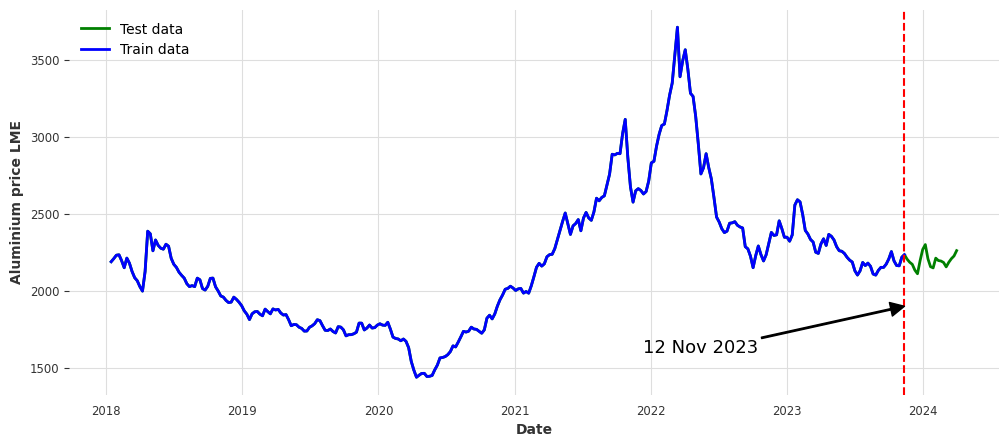

In [32]:
fig, ax = plt.subplots(figsize=(12, 5))
data_ts.plot(label="Test data", color='g')
ts.plot(label="Train data", color='b')
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
ax.annotate('12 Nov 2023', xy=(ts.end_time(), 1900), xytext=(ts.end_time() - datetime.timedelta(700), 1600),
            arrowprops=dict(facecolor='black', width=1, headwidth=10, headlength=10), fontsize = 13
            )
ax.set_ylabel('Aluminium price LME');
ax.set_xlabel('Date');
#plt.savefig('preview.png', dpi=400, format='png')

# ARIMA

In [21]:
model = AutoARIMA(start_p=2, d=None, start_q=2, max_p=10, max_d=3, max_q=10, start_P=1, D=None, 
                  start_Q=1, max_P=5, max_D=5, max_Q=5, max_order=10, m=1, seasonal=True, stationary=False, 
                  information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb',
                  stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=5000, 
                  offset_test_args=None, seasonal_test_args=None, suppress_warnings=True,
                  error_action='trace', trace=False, random=False, random_state=None, n_fits=10,
                  out_of_sample_size=0, scoring='mse', with_intercept='auto')
model.fit(ts)
pred = model.predict(20)

In [22]:
mape(data_ts, pred)

2.335979380689468

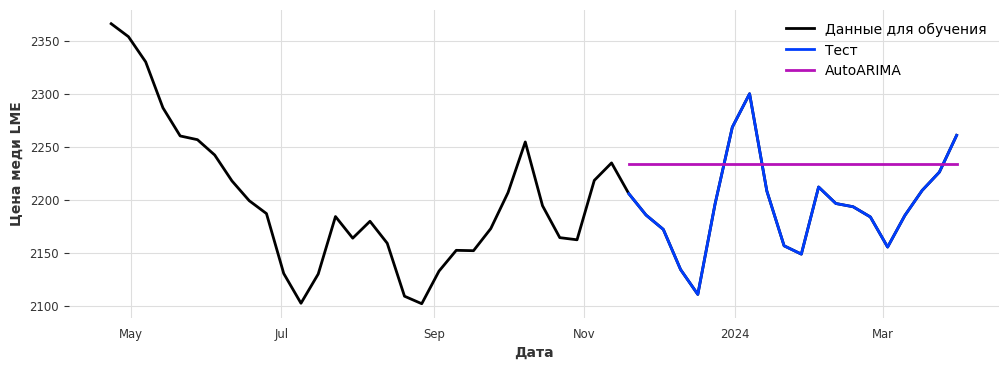

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))
data_ts[-50:].plot(label="Данные для обучения")
data_ts[-OUT_OF_TIME_DIM:].plot(label="Тест")
pred.plot(label="AutoARIMA")
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
plt.savefig('arima.png', dpi=400, format='png')

# Linear regression

### Cross-validation

In [24]:
def manual_backtest(model_settings,
                    ts,
                    past_covariates,
                    forecast_horizont=FORECAST_LEN, 
                    start_test=180,
                    step = 10,
                    save_curves=False,
                    rolling_window=False,
                    window_size=None,
                    verbose=True
                   ):
    '''
    Функция аналогична встроенной функции backtest
    '''
    metrics = list() # Список для метрик
    prediction_curves = dict() # Список для последюущей визуализации кривых
    k=1
    # Скользящее или расширяющееся окно
    if rolling_window: 
        start_train = start_test - window_size
    else:
        start_train=0
    while True:
        if verbose is True:
            print('Iter #', k)
        cur_train = ts[start_train : start_test]
        cur_test = ts[start_test : start_test + int(forecast_horizont)]
        # Инициализация scaler-ов
        scaler_ts, scaler_past_cov = Scaler(), Scaler()
        # Есть ли экзогенные признаки
        if past_covariates is not None:
            past_cov_train = past_covariates[start_train : start_test]
            past_cov_test = past_covariates[start_test : start_test + int(forecast_horizont)]
            
            cur_train_scaled = scaler_ts.fit_transform(cur_train)
            past_cov_train_scaled = scaler_past_cov.fit_transform(past_cov_train)
            cur_test_scaled = scaler_ts.transform(cur_test)
            past_cov_test_scaled = scaler_past_cov.transform(past_cov_test)
            
            model = LinearRegressionModel(
                **model_settings,
                output_chunk_length=FORECAST_LEN,
                random_state=42)
            model.fit(series=cur_train_scaled,
                      past_covariates=past_cov_train_scaled)
            cur_pred_scaled = model.predict(int(forecast_horizont),
                                            series=cur_train_scaled,
                                            past_covariates=past_cov_train_scaled)
            cur_pred = scaler_ts.inverse_transform(cur_pred_scaled)
        # Если экзогенных признаков нет  
        else:
            cur_train_scaled = scaler_ts.fit_transform(cur_train)
            cur_test_scaled = scaler_ts.transform(cur_test)
            
            model = LinearRegressionModel(
                **model_settings,
                output_chunk_length=FORECAST_LEN,
                random_state=42)
            model.fit(series=cur_train_scaled)
            cur_pred_scaled = model.predict(int(forecast_horizont),
                                             series=cur_train_scaled)
            cur_pred = scaler_ts.inverse_transform(cur_pred_scaled)
        # Вычисляем метрику и добавляем в список   
        metric = mape(cur_test, cur_pred, intersect=True)
        metrics.append(metric)

        # Добавляем спрогнозированную кривую в набор кривых для последующей отрисовки
        prediction_curves['pred_'+str(k)]=cur_pred
        k+=1
        
        start_test+=step
        if rolling_window:
            start_train+=step
        if start_test + int(forecast_horizont) > len(ts):
            break
            
    if save_curves==True:
        return metrics, prediction_curves
    else:
        return metrics

### Hyperparameter optimization (optuna)

In [25]:
class LoggingCallback:
    def __init__(self, interval=5):
        self.interval = interval

    def __call__(self, study, trial):
        if trial.number % self.interval == 0:
            print(f"Trial number: {trial.number}, Trial value: {trial.value:.2f}, Trial params: {trial.params}", end='\n\n')
            print(f"Best trial: {study.best_trial.number}, Best value: {study.best_value:.2f}, Best params: {study.best_trial.params}", end='\n\n')

In [26]:
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [27]:
def objective(trial, ts, past_cov, forecast_len = FORECAST_LEN):
    
    settings = {
        "lags" : trial.suggest_int("lags", 1, 60),
        "lags_past_covariates" : trial.suggest_int("lags_past_covariates", 1, 60)
    }
    settings_for_backtest = {
        "rolling_window" : trial.suggest_categorical("rolling_window", [True, False])
    }
    if settings_for_backtest["rolling_window"] == True:
        settings_for_backtest["window_size"] = trial.suggest_categorical("window_size", [104, 156])

    # Evaluate how good it is on the cross_validation for ts
    metrics = manual_backtest(settings,
                              ts=ts,
                              past_covariates=past_cov,
                              **settings_for_backtest,
                              verbose=False
                             )
    mean_metric = np.mean(metrics)
    return mean_metric if mean_metric != np.nan else float("inf")

def opt(ts, past_cov, iterations):
    opt_function=partial(objective, ts=ts, past_cov=past_cov)
    study = optuna.create_study(direction="minimize")
    study.optimize(opt_function, n_trials=iterations, callbacks=[LoggingCallback()])
    print("Number of finished trials: {}".format(len(study.trials)), end='\n\n')
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}", end='\n\n')
    return study

In [28]:
def setup_params(best_params):
    if best_params['rolling_window']==True:
        settings_for_backtest = {
            'rolling_window':True,
            'window_size': best_params['window_size']
        }
        del best_params['rolling_window']
        del best_params['window_size']
    else:
        settings_for_backtest = {
            'rolling_window':False
        }
        del best_params['rolling_window']
    return best_params, settings_for_backtest

In [29]:
def fit_model(model_settings,
              backtest_settings,
              ts,
              past_cov=None,
              forecast_len=FORECAST_LEN):
    
    input_size = max(model_settings["lags"], model_settings["lags_past_covariates"])
    
    if past_cov is not None:
        scaler_ts = Scaler()
        scaler_past_cov = Scaler()
        
        if backtest_settings["rolling_window"]==True:
            window_size = backtest_settings["window_size"]
            ts_train = ts[-window_size : ]
            past_cov_train = past_cov[-window_size : ]
        else:
            ts_train = ts
            past_cov_train = past_cov
        
        ts_train_scaled = scaler_ts.fit_transform(ts_train)
        past_cov_train_scaled = scaler_past_cov.fit_transform(past_cov_train)
        model = LinearRegressionModel(**model_settings,
                                      output_chunk_length=FORECAST_LEN,
                                      random_state=42)
        model.fit(series=ts_train_scaled,
                  past_covariates=past_cov_train_scaled)
        
        return model, scaler_ts, scaler_past_cov

In [30]:
def evaluation(model_settings,
               backtest_settings,
               data_ts,
               data_past_cov,
               forecast_len=FORECAST_LEN,
               out_of_time_dim=OUT_OF_TIME_DIM,
               refit = None
              ):
    '''
    Функция для построения прогноза и вычисления метрик на out-of-time выборке
    data_ts - датасет временного ряда
    data_past_cov - датасет ковариант
    model_settings и backtest_settings - настройки модели,
    forecast_len - длина прогноза,
    out_of_time_dim - размер выборки out-of-time
    '''
    start_point = 0
    metrics = list()
    prediction_curves = {}
    step = 1
    input_size = max(model_settings["lags"], model_settings["lags_past_covariates"])
    original_ts = data_ts.copy()
    out_of_time_ts = data_ts[-(out_of_time_dim + input_size):]
    out_of_time_past_cov = data_past_cov[-(out_of_time_dim + input_size):]
    if refit == True:
        while True:
            train_ts = data_ts[:-out_of_time_dim+start_point]
            train_past_cov = data_past_cov[:-out_of_time_dim+start_point]
            
            model, scaler_ts, scaler_past_cov = fit_model(model_settings=model_settings,
                                                          backtest_settings=backtest_settings,
                                                          ts=train_ts,
                                                          past_cov=train_past_cov
                                                         )
            test_ts = out_of_time_ts[start_point : start_point + input_size]
            test_past_cov = out_of_time_past_cov[start_point : start_point + input_size]
            test_ts_scaled = scaler_ts.transform(test_ts)
            test_past_cov_scaled = scaler_past_cov.transform(test_past_cov)
            
            prediction_scaled = model.predict(n=int(forecast_len))
            prediction = scaler_ts.inverse_transform(prediction_scaled)
            
            metric = mape(prediction, original_ts, intersect=True)
            metrics.append(metric)
            
            start_point+=step
            prediction_curves[start_point]=prediction
            if start_point + input_size + int(forecast_len) > len(out_of_time_ts):
                break
        print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
        return prediction_curves, metrics, model, scaler_ts, scaler_past_cov
    
    elif refit == False:
        train_ts = data_ts[:-out_of_time_dim]
        train_past_cov = data_past_cov[:-out_of_time_dim]
        print("Building model")
        model, scaler_ts, scaler_past_cov = fit_model(model_settings=model_settings,
                                                      backtest_settings=backtest_settings,
                                                      ts=train_ts,
                                                      past_cov=train_past_cov
                                                     )
        while True:
            test_ts = out_of_time_ts[start_point : start_point + input_size]
            test_past_cov = out_of_time_past_cov[start_point : start_point + input_size]
            test_ts_scaled = scaler_ts.transform(test_ts)
            test_past_cov_scaled = scaler_past_cov.transform(test_past_cov)
            
            prediction_scaled = model.predict(n=int(forecast_len))
            prediction = scaler_ts.inverse_transform(prediction_scaled)
            
            metric = mape(prediction, original_ts, intersect=True)
            metrics.append(metric)
            
            start_point+=step
            prediction_curves[start_point]=prediction
            if start_point + input_size + int(forecast_len) > len(out_of_time_ts):
                break
        print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
        return prediction_curves, metrics, model, scaler_ts, scaler_past_cov
    
    else:
        print("Установите значение параметра refit!")
        pass

## Build models

### Hyperparameter optimization with all features

In [31]:
study = opt(ts=ts, past_cov=past_cov, iterations=100)

Trial number: 0, Trial value: 9.39, Trial params: {'lags': 34, 'lags_past_covariates': 7, 'rolling_window': True, 'window_size': 104}

Best trial: 0, Best value: 9.39, Best params: {'lags': 34, 'lags_past_covariates': 7, 'rolling_window': True, 'window_size': 104}

Trial number: 5, Trial value: 7.93, Trial params: {'lags': 41, 'lags_past_covariates': 54, 'rolling_window': False}

Best trial: 1, Best value: 6.76, Best params: {'lags': 58, 'lags_past_covariates': 32, 'rolling_window': False}

Trial number: 10, Trial value: 8.27, Trial params: {'lags': 18, 'lags_past_covariates': 21, 'rolling_window': True, 'window_size': 156}

Best trial: 7, Best value: 6.22, Best params: {'lags': 28, 'lags_past_covariates': 3, 'rolling_window': False}

Trial number: 15, Trial value: 20.91, Trial params: {'lags': 46, 'lags_past_covariates': 13, 'rolling_window': False}

Best trial: 7, Best value: 6.22, Best params: {'lags': 28, 'lags_past_covariates': 3, 'rolling_window': False}

Trial number: 20, Trial 

In [33]:
best_settings = study.best_trial.params
best_params, settings_for_backtest = setup_params(best_settings)

In [34]:
best_params

{'lags': 43, 'lags_past_covariates': 60}

In [35]:
settings_for_backtest

{'rolling_window': True, 'window_size': 104}

### Backtest with refit on each step

In [36]:
bt_metrics, pred_ts = manual_backtest(model_settings=best_params,
                                      ts=ts,
                                      past_covariates=past_cov,
                                      save_curves=True,
                                      **settings_for_backtest)

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13


In [37]:
print("Backtest MAPE: {:.2f} +- {:.2f}".format(np.mean(bt_metrics), np.std(bt_metrics)))

Backtest MAPE: 5.85 +- 4.39


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

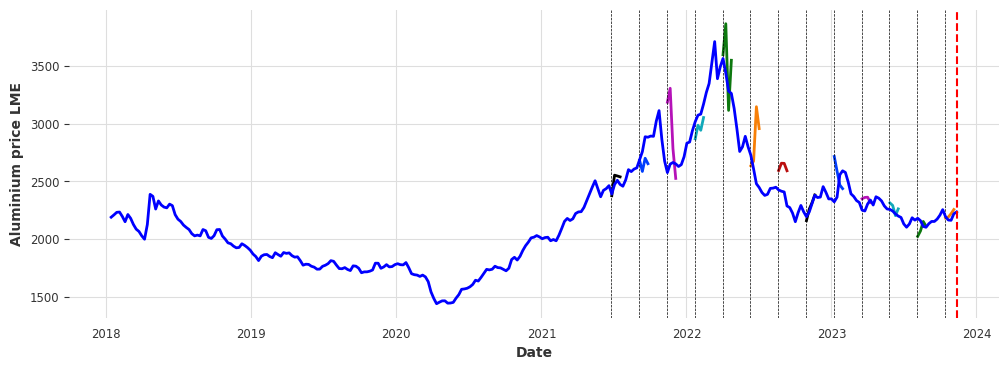

In [38]:
fig, ax = plt.subplots(figsize=(12, 4))
for key, value in pred_ts.items():
    value.plot(label=None);
    ax.axvline(x=value.start_time() - datetime.timedelta(1), color='black', linestyle='--', linewidth=0.5)
ts.plot(color='blue', label=None)
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
ax.set_ylabel('Aluminium price LME');
ax.set_xlabel('Date');
plt.savefig('Backtest_linear_model.png', dpi=400, format='png')

### Fit and evaluate without refitting

In [39]:
prediction_curves_without_refit, \
metrics_without_refit, \
model_non_refited, \
scaler_ts_without_refit, \
scaler_past_cov_without_refit = evaluation(model_settings=best_params,
                                           backtest_settings=settings_for_backtest,
                                           data_ts=data_ts,
                                           data_past_cov=data_past_cov,
                                           forecast_len=FORECAST_LEN,
                                           out_of_time_dim=OUT_OF_TIME_DIM,
                                           refit = False)

Building model
MAPE: 3.49 +- 0.00


<Axes: xlabel='date'>

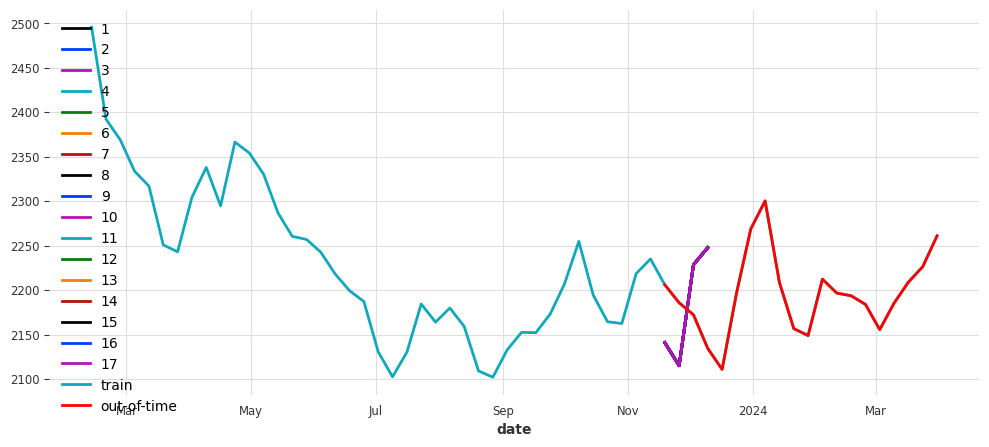

In [40]:
plt.figure(figsize=(12,5))
for key, value in prediction_curves_without_refit.items():
    value.plot(label=key)
data_ts[-3*OUT_OF_TIME_DIM:].plot(label='train')
data_ts[-OUT_OF_TIME_DIM:].plot(label='out-of-time', color='r')

**Линейная модель не пашет без переобучения!!!**

### Fit and evaluate with refitting

In [41]:
prediction_curves_with_refit, \
metrics_with_refit, \
model_refited, \
scaler_ts_with_refit, \
scaler_past_cov_with_refit = evaluation(model_settings=best_params,
                                           backtest_settings=settings_for_backtest,
                                           data_ts=data_ts,
                                           data_past_cov=data_past_cov,
                                           forecast_len=FORECAST_LEN,
                                           out_of_time_dim=OUT_OF_TIME_DIM,
                                           refit = True)

MAPE: 3.51 +- 0.84


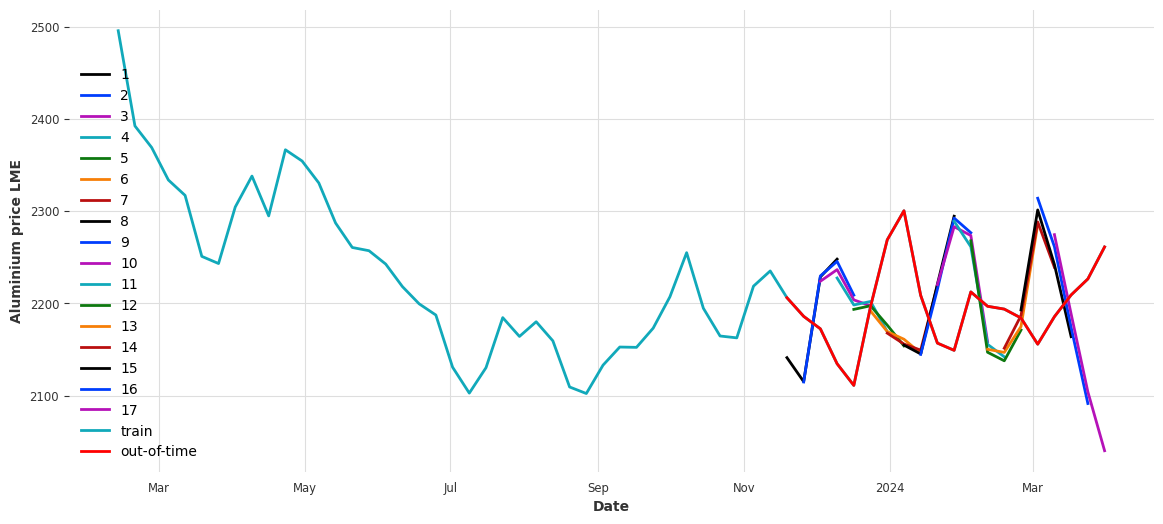

In [42]:
fig, ax = plt.subplots(figsize=(14, 6))
for key, value in prediction_curves_with_refit.items():
    value.plot(label=key)
data_ts[-3*OUT_OF_TIME_DIM:].plot(label='train')
data_ts[-OUT_OF_TIME_DIM:].plot(label='out-of-time', color='r')
ax.set_ylabel('Aluminium price LME');
ax.set_xlabel('Date');
plt.savefig('Out_of_time_test_linear_model.png', dpi=400, format='png')